# Bank Classification Project - Preprocessing

In [1]:
# Imports
%matplotlib inline

import timeit

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, RandomizedPCA, KernelPCA

In [2]:
bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', 
                        sep=';', na_values=['NA'])

## Preprocessing

In [3]:
# Change yes/no to binary
bank_data = bank_data.replace(['yes', 'no'], [1, 0])

In [4]:
# Move y to front for readability
cols = bank_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
bank_data = bank_data[cols]

In [5]:
# Replace 'unknown' with NAN and drop them
# I could potentially use an imputation strategy...
bank_data.replace(['unknown'], [np.nan], inplace=True)
bank_data = bank_data.dropna()

In [6]:
# Remove due to look-ahead bias
del bank_data['duration']

In [7]:
# Get dummy variables for categorical features    
columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']    
bank_data = pd.get_dummies(bank_data, columns=columns)

In [8]:
pickle.dump(bank_data, open('data/bank_data.pkl', 'wb'))

In [9]:
bank_data.head()

,y,age,default,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,56,0.0,0.0,0.0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
2,0,37,0.0,1.0,0.0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
3,0,40,0.0,0.0,0.0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
4,0,56,0.0,0.0,1.0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
6,0,59,0.0,0.0,0.0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0


In [10]:
# Train test split
X, y = bank_data.iloc[:, 1:].values, bank_data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

 1) age                            0.170379
 2) euribor3m                      0.124229
 3) campaign                       0.087133
 4) nr.employed                    0.052300
 5) housing                        0.041105
 6) pdays                          0.036028
 7) cons.conf.idx                  0.026229
 8) loan                           0.025608
 9) emp.var.rate                   0.025252
10) cons.price.idx                 0.023973
11) poutcome_success               0.023025
12) job_admin.                     0.018470
13) marital_married                0.017256
14) education_university.degree    0.016885
15) education_high.school          0.016533
16) marital_single                 0.015738
17) previous                       0.015140
18) job_technician                 0.014783
19) day_of_week_mon                0.014573
20) day_of_week_tue                0.014436
21) day_of_week_thu                0.014227
22) day_of_week_wed                0.014136
23) day_of_week_fri             

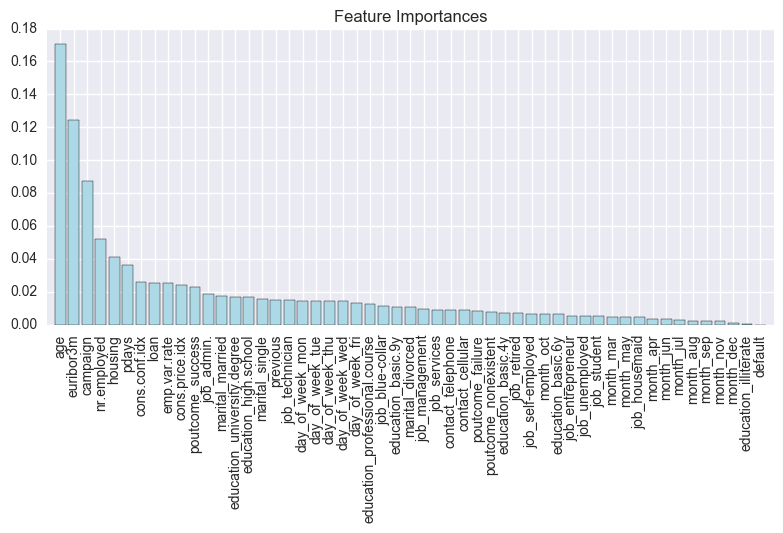

In [11]:
# Feature importance with Random Forests
feat_labels = bank_data.columns[1:]

forest = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
# plt.savefig('./images/random_forest.png', dpi=300)
plt.show()

## Dimensionality Reduction

In [12]:
# Bringing features on the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Linear methods

In [13]:
pca = PCA(n_components=5)
%timeit X_train_pca = pca.fit_transform(X_train_std)

1 loop, best of 3: 212 ms per loop


In [14]:
rpca = RandomizedPCA(5)
%timeit rpca.fit_transform(X_train_std)

/Users/osx10/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


10 loops, best of 3: 93.7 ms per loop


In [15]:
# Randomized PCA has been deprecated, use original class
rpca = PCA(n_components=5, svd_solver='randomized')
%timeit X_train_rpca = rpca.fit_transform(X_train_std)

1 loop, best of 3: 210 ms per loop


New implementation is incredibly slow. What is the scikit-learn dev team doing?

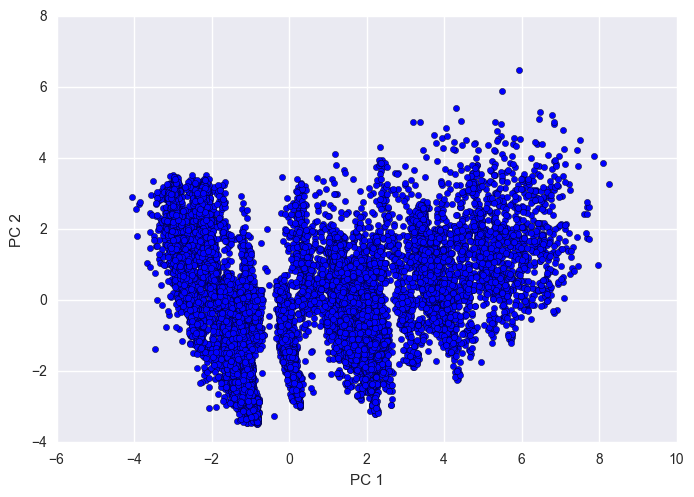

In [16]:
X_train_pca = pca.fit_transform(X_train_std)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [17]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

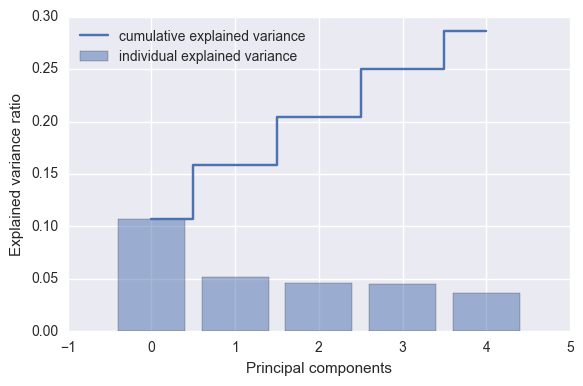

In [18]:
plt.figure(figsize=(6, 4))
plt.bar(range(5), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(5), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

PCA is not able to explain much variance. Rather not use principal components in the pipeline and stick to the regular variables. Other supervised or non-linear dimensionality reduction techniques could prove useful to explore.

### Non-linear methods

In [19]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X_train_std)

In [20]:
kpca_1 = X_kpca[:, 0]
kpca_2 = X_kpca[:, 1]

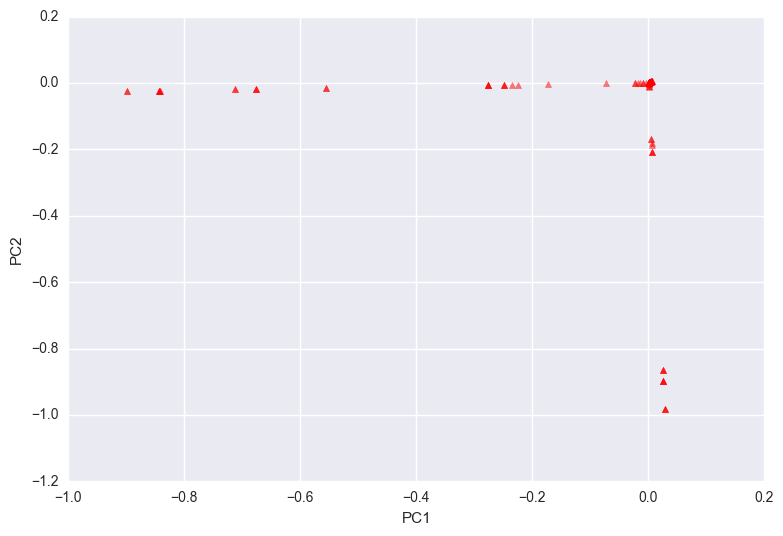

In [21]:
plt.scatter(kpca_1, kpca_2, color='red', marker='^', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('./images/scikit_kpca.png', dpi=300)
plt.show()

In [22]:
# Try manifold learning